# Distillation via x0 prediction 

## Imports

In [1]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2



c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


## Load Models

In [10]:
config_path=f"{cwd}/models/configs/cin256-v2-x0_1024.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Test teacher:

In [9]:
config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher2 = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [11]:
xc = torch.tensor([992])
timesteps =  400
teacher.num_timesteps=timesteps
c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
img, x0, x_T_copy = teacher.progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=None, start_T=None,
                              log_every_t=None)

Progressive Generation:   0%|          | 0/400 [00:00<?, ?it/s]


AttributeError: 'LatentDiffusion' object has no attribute 'sqrt_recip_alphas_cumprod'

# Custom Schedule, Important

In [2]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2


config_path=f"{cwd}/models/configs/cin256-v2-x0_1024.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False)

timesteps =  400
# uc = teacher.get_learned_conditioning({teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)})
xc = torch.tensor([992])
# teacher.reregister_schedule(timesteps=1000,beta_schedule="linear", linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3, force=True)
# teacher.register_schedule(given_betas=None, beta_schedule="cosine", timesteps=timesteps)
# teacher.logvar = torch.full(fill_value=0., size=(teacher.num_timesteps,))
teacher.num_timesteps=timesteps
c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
img, x0, x_T_copy = teacher.progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=None, start_T=None,
                              log_every_t=None)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Progressive Generation: 100%|██████████| 400/400 [00:22<00:00, 17.82it/s]


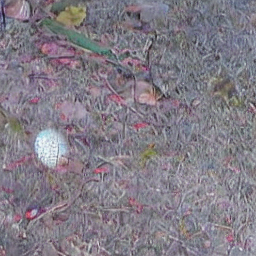

In [3]:
latent_to_img(teacher, img)

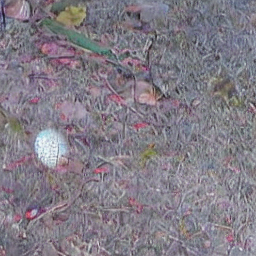

In [4]:
latent_to_img(teacher, x0)

# Teacher predicting in steps

In [1]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-x0.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False)


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [6]:
NUM_CLASSES = 1000
generations = 1
# intermediate_generation = generations // 5
ddim_steps_teacher = 400
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.01
scale = 3.0
updates = int(ddim_steps_teacher / TEACHER_STEPS)


teacher.num_timesteps = ddim_steps_teacher

with torch.no_grad():
    with teacher.ema_scope():
            
            # for class_prompt in tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))):
            
            with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:
                
                for i, class_prompt in enumerate(tepoch):
                    img = None
                    # xc = torch.tensor([class_prompt])
                    xc = torch.tensor([992])
                    c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})

                    for steps in range(updates):          
                                                     
                        img, x0, x_T_copy = teacher.iterative_progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=img, start_T=steps*2,
                              log_every_t=None, keep_intermediates=True)
                        

100%|██████████| 1/1 [00:22<00:00, 22.09s/it]


# Generate a prediction

In [4]:
image, _, _ = generate(teacher, steps=400, x0=True)

Progressive Generation: 100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


# Training student on teacher

In [ ]:
NUM_CLASSES = 1000
generations = generations
intermediate_generation = generations // 5
ddim_steps_teacher = steps
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.01
scale = 3.0
updates = int(ddim_steps_teacher / TEACHER_STEPS)
optimizer=optimizer
averaged_losses = []
teacher_samples = list()
criterion = nn.MSELoss()
instance = 0
generation = 0


a_t = np.linspace(0, 1, updates)

all_losses = []
ets = []
with torch.no_grad():
    with student.ema_scope():
            
            sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
            sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
            # for class_prompt in tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))):
            uc = teacher.get_learned_conditioning(
                        {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                        )
            sc = teacher.get_learned_conditioning(
                        {teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)}
                        )
            with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:
                for i, class_prompt in enumerate(tepoch):
                    
        

                    generation += 1
                    losses = []        
                    xc = torch.tensor([class_prompt])
                    c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                    c_student = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                    x_T = None
                    
                    for steps in range(updates):          
                                instance += 1
                                
                                # sampler_teacher.make_schedule(ddim_num_steps=ddim_steps_teacher, ddim_eta=ddim_eta, verbose=False)
                                samples_ddim_teacher, teacher_intermediate, x_T, pred_x0_teacher, a_t_teacher, e_t_teacher = sampler_teacher.sample(S=TEACHER_STEPS,
                                                                conditioning=c,
                                                                batch_size=1,
                                                                shape=[3, 64, 64],
                                                                verbose=False,
                                                                x_T=x_T,
                                                                # quantize_x0 = True,
                                                                unconditional_guidance_scale=scale,
                                                                # unconditional_conditioning=uc, 
                                                                eta=ddim_eta,
                                                                keep_intermediates=False,
                                                                intermediate_step = steps*TEACHER_STEPS,
                                                                steps_per_sampling = TEACHER_STEPS,
                                                                total_steps = ddim_steps_teacher)      
                                
                            

                                # x_T_teacher = teacher_intermediate["x_inter"][-1]
                                
                                # x_T_teacher_decode = sampler_teacher.model.decode_first_stage(samples_ddim_teacher)
                                # x_T_teacher = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
                                
                                # teacher_target = torch.clamp((x_T_teacher_decode+1.0)/2.0, min=0.0, max=1.0)
                                

                                with torch.enable_grad():
                                    # sampler_student.make_schedule(ddim_num_steps=ddim_steps_student, ddim_eta=ddim_eta, verbose=False)
                                    optimizer.zero_grad()
                                    samples_ddim_student, student_intermediate, x_T_copy, a_t, pred_x0_student, sigma_t, e_t_student= sampler_student.sample_student(S=STUDENT_STEPS,
                                                                    conditioning=c_student,
                                                                    batch_size=1,
                                                                    shape=[3, 64, 64],
                                                                    verbose=False,
                                                                    x_T=x_T,
                                                                    # quantize_x0 = True,
                                                                    unconditional_guidance_scale=scale,
                                                                    # unconditional_conditioning=c, 
                                                                    eta=ddim_eta,
                                                                    keep_intermediates=False,
                                                                    intermediate_step = steps*STUDENT_STEPS,
                                                                    steps_per_sampling = STUDENT_STEPS,
                                                                    total_steps = ddim_steps_student)
                                    
                                    # x_T_student = student_intermediate["x_inter"][-1]
                                    
                                    # print("len samples ddim:", samples_ddim_student.shape)
                                    # x_T_student_decode = sampler_student.model.differentiable_decode_first_stage(samples_ddim_student)
                                    # student_target  = torch.clamp((x_T_student_decode +1.0)/2.0, min=0.0, max=1.0)
                                    # loss = max(math.log(a_t**2 / (1-a_t) **2), 1) *  criterion(samples_ddim_student, samples_ddim_teacher)
                                    # loss = math.log(a_t / (sigma_t)) * criterion(pred_x0_student, pred_x0_teacher)
                                    # loss =  abs(math.log(a_t / (1-a_t))) * criterion(e_t_student, e_t_teacher)
                                    loss = math.log(a_t**2 / (1-a_t) **2) * criterion(e_t_student, e_t_teacher)
                                    
                                    # loss =  criterion(samples_ddim_student, samples_ddim_teacher)
                                    # loss = max(math.log(a_t / (1-a_t)), 1) *  criterion(x_T_student, x_T)
                                    # loss = max(math.log(a_t / (1-a_t)), 1) *  criterion(x_T_student_decode, x_T_teacher_decode) 
                                    # print("stp:", steps, "Lss:", loss.item(), end="--")    
                                                            
                                    loss.backward()
                                    
                                    # print(math.log(a_t**2 / (sigma_t ** 2)))
                                    
                                    # torch.nn.utils.clip_grad_norm_(sampler_student.model.parameters(), 1)
                                    
                                    optimizer.step()
                                    scheduler.step()
                                    losses.append(loss.item())
                                    if session != None:
                                        session.log({"intermediate_loss":loss.item()})

                            

                            # del samples_ddim, samples_ddim_student, teacher_intermediate, student_intermediate, x_T_copy, a_t, pred_x0_student
                            # torch.cuda.empty_cache()

                    # with torch.no_grad():
                    #     if generation > 2 and generation % intermediate_generation == 0:
                    #         save_model(sampler_student, optimizer, scheduler, name=f"intermediate_{instance}", steps=ddim_steps_student, run_name=run_name)
                    #         images, grid = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 6, 8, 10, 16, 20, 32, 64, 128])
                    #         images = wandb.Image(grid, caption=f"{instance} steps, left: Teacher, right: Student")
                    #         wandb.log({"Intermediate": images})
                    
                    
                    
                    all_losses.extend(losses)
                    # print(scheduler.get_last_lr())
                    averaged_losses.append(sum(losses) / len(losses))
                    if session != None:
                        session.log({"generation_loss":averaged_losses[-1]})
                    tepoch.set_postfix(epoch_loss=averaged_losses[-1])
                    torch.cuda.empty_cache()
                    if early_stop == True and i > 1:
                        if averaged_losses[-1] > (10*losses[-2]):
                            print(f"Early stop initiated: Prev loss: {round(averaged_losses[-2], 5)}, Current loss: {round(averaged_losses[-1], 5)}")
                            plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
                            plt.xlabel("Generations")
                            plt.ylabel("px MSE")
                            plt.title("MSEloss student vs teacher")
                            plt.show()
                                

                                                        
plt.plot(range(len(all_losses)), all_losses, label="MSE LOSS")
plt.xlabel("Generations")
plt.ylabel("px MSE")
plt.title("MSEloss student vs teacher")
plt.show()
